In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#Bring in our data
game_details = pd.read_csv('games_details.csv')
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
ranking = pd.read_csv('ranking.csv')
teams = pd.read_csv('teams.csv')
pd.set_option('display.max_columns', None)
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-03-01,21900895,Final,1610612766,1610612749,2019,1610612766,85.0,0.354,0.900,0.229,22.0,47.0,1610612749,93.0,0.402,0.762,0.226,20.0,61.0,0
1,2020-03-01,21900896,Final,1610612750,1610612742,2019,1610612750,91.0,0.364,0.400,0.310,19.0,57.0,1610612742,111.0,0.468,0.632,0.275,28.0,56.0,0
2,2020-03-01,21900897,Final,1610612746,1610612755,2019,1610612746,136.0,0.592,0.805,0.542,25.0,37.0,1610612755,130.0,0.505,0.650,0.488,27.0,37.0,1
3,2020-03-01,21900898,Final,1610612743,1610612761,2019,1610612743,133.0,0.566,0.700,0.500,38.0,41.0,1610612761,118.0,0.461,0.897,0.263,24.0,36.0,1
4,2020-03-01,21900899,Final,1610612758,1610612765,2019,1610612758,106.0,0.407,0.885,0.257,18.0,51.0,1610612765,100.0,0.413,0.667,0.429,23.0,42.0,1


In [3]:
#Create a smaller table for the purpose of bringing in team abreviations into the games df as it currently only has team ID
team_abv = teams[['TEAM_ID','ABBREVIATION']]
games_new = games.merge(team_abv,left_on = 'HOME_TEAM_ID', right_on = 'TEAM_ID').merge(team_abv,left_on = 'VISITOR_TEAM_ID', right_on = 'TEAM_ID')
games_new.rename(columns={'ABBREVIATION_x':'ABV_HOME',
                         'ABBREVIATION_y':'ABV_AWAY'}, 
                 inplace=True)

#Use only the columns we care about as there was some repition amoung columns
g = games_new[['GAME_ID','GAME_DATE_EST','SEASON','HOME_TEAM_WINS','ABV_HOME','PTS_home','AST_home','FG_PCT_home','FT_PCT_home','FG3_PCT_home','ABV_AWAY','PTS_away','FG_PCT_away','FT_PCT_away','FG3_PCT_away']]
#Need to filter teams down into just ID and ABV
#then join in twice to games for home and vistor ID. Rename abv columns according to home or away
g.head(3)

,GAME_ID,GAME_DATE_EST,SEASON,HOME_TEAM_WINS,ABV_HOME,PTS_home,AST_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,ABV_AWAY,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away
0,21900895,2020-03-01,2019,0,CHA,85.0,22.0,0.354,0.900,0.229,MIL,93.0,0.402,0.762,0.226
1,21900669,2020-01-24,2019,0,CHA,103.0,24.0,0.372,0.833,0.359,MIL,116.0,0.506,0.750,0.278
2,21300407,2013-12-23,2013,1,CHA,111.0,30.0,0.434,0.750,0.588,MIL,110.0,0.433,0.941,0.357


C:\Users\charl\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\charl\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


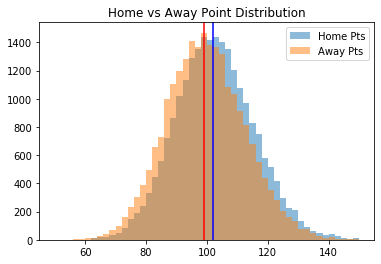

In [4]:
plt.hist('PTS_home',data=g, bins = 50, range= (50,150),alpha = .5, label = 'Home Pts')
plt.hist('PTS_away',data=g, bins  =50, range=(50,150),alpha = .5, label = 'Away Pts')
plt.title('Home vs Away Point Distribution')
plt.legend()

home_median = g.PTS_home.median()
away_median = g.PTS_away.median()
plt.axvline(home_median, color = 'blue')
plt.axvline(away_median, color = 'red')
plt.show()

Text(0.5, 1.0, 'Average Home Assist per Season')

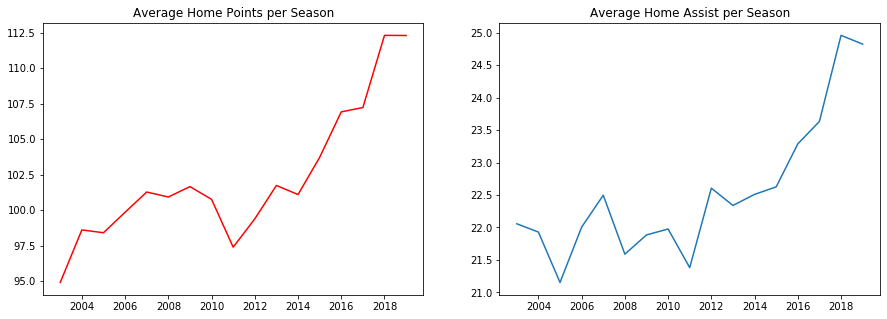

In [5]:
#Group stats by season
season_gp = g.groupby('SEASON').mean().reset_index()


fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(season_gp.SEASON, season_gp.PTS_home, color = 'r')
plt.title('Average Home Points per Season')
plt.subplot(1,2,2)
plt.plot(season_gp.SEASON, season_gp.AST_home)
plt.title('Average Home Assist per Season')

#This isn't relevant to our overall analysis and predictive model, but it is still interesting

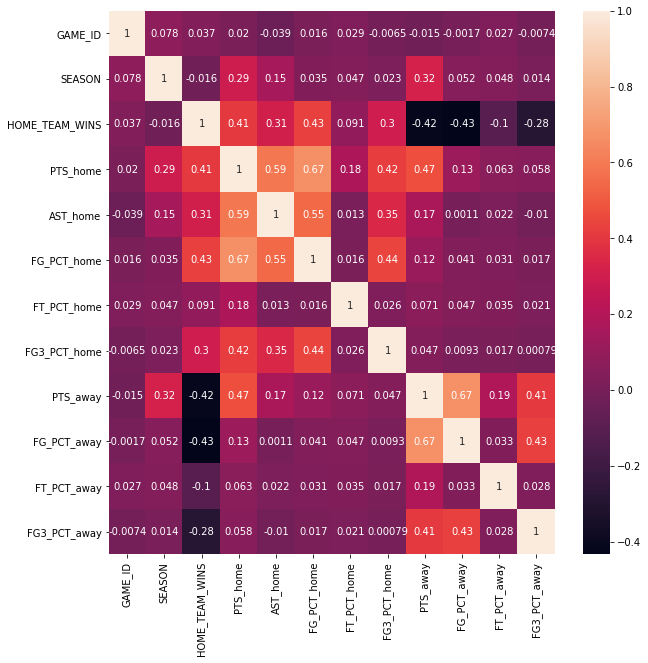

In [6]:
#Find correlations in the game outcome and stats of THAT game
#Basically all below stats have some effect on wins except for free throws
plt.figure(figsize=(10,10))
sns.heatmap(g.corr(), annot = True)

Next lets see if a team's ave stats in these categories have a correlation on wins rather than just comparing a certain games stats to that game outcome

Also lets add some stats from the game_details df like rebounds 

To do this we need to take the game_details and group by gameID

In [7]:
game_details.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,21900895,1610612749,MIL,Milwaukee,202083,Wesley Matthews,F,NaN,27:08,3.0,11.0,0.273,2.0,7.0,0.286,0.0,0.0,0.000,4.0,4.0,8.0,2.0,2.0,0.0,0.0,0.0,8.0,11.0
1,21900895,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,F,NaN,34:55,17.0,28.0,0.607,1.0,4.0,0.250,6.0,7.0,0.857,2.0,18.0,20.0,6.0,1.0,0.0,3.0,2.0,41.0,22.0
2,21900895,1610612749,MIL,Milwaukee,201572,Brook Lopez,C,NaN,26:25,4.0,11.0,0.364,1.0,5.0,0.200,7.0,9.0,0.778,2.0,5.0,7.0,0.0,0.0,3.0,0.0,2.0,16.0,16.0
3,21900895,1610612749,MIL,Milwaukee,1628978,Donte DiVincenzo,G,NaN,27:35,1.0,5.0,0.200,0.0,3.0,0.000,0.0,0.0,0.000,1.0,6.0,7.0,5.0,0.0,1.0,2.0,0.0,2.0,14.0
4,21900895,1610612749,MIL,Milwaukee,202339,Eric Bledsoe,G,NaN,22:17,2.0,8.0,0.250,0.0,1.0,0.000,0.0,0.0,0.000,1.0,0.0,1.0,2.0,1.0,0.0,3.0,2.0,4.0,6.0


In [8]:
#Create a game_details df that has home wins included
full_dets = game_details.merge(g[['GAME_ID','ABV_HOME','HOME_TEAM_WINS']],left_on = 'GAME_ID', right_on='GAME_ID')
full_dets.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,ABV_HOME,HOME_TEAM_WINS
0,21900895,1610612749,MIL,Milwaukee,202083,Wesley Matthews,F,NaN,27:08,3.0,11.0,0.273,2.0,7.0,0.286,0.0,0.0,0.000,4.0,4.0,8.0,2.0,2.0,0.0,0.0,0.0,8.0,11.0,CHA,0
1,21900895,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,F,NaN,34:55,17.0,28.0,0.607,1.0,4.0,0.250,6.0,7.0,0.857,2.0,18.0,20.0,6.0,1.0,0.0,3.0,2.0,41.0,22.0,CHA,0
2,21900895,1610612749,MIL,Milwaukee,201572,Brook Lopez,C,NaN,26:25,4.0,11.0,0.364,1.0,5.0,0.200,7.0,9.0,0.778,2.0,5.0,7.0,0.0,0.0,3.0,0.0,2.0,16.0,16.0,CHA,0
3,21900895,1610612749,MIL,Milwaukee,1628978,Donte DiVincenzo,G,NaN,27:35,1.0,5.0,0.200,0.0,3.0,0.000,0.0,0.0,0.000,1.0,6.0,7.0,5.0,0.0,1.0,2.0,0.0,2.0,14.0,CHA,0
4,21900895,1610612749,MIL,Milwaukee,202339,Eric Bledsoe,G,NaN,22:17,2.0,8.0,0.250,0.0,1.0,0.000,0.0,0.0,0.000,1.0,0.0,1.0,2.0,1.0,0.0,3.0,2.0,4.0,6.0,CHA,0


In [9]:
#Using hometeam win to create a standard 'win' column
full_dets['WIN'] = np.where(full_dets['TEAM_ABBREVIATION']==full_dets['ABV_HOME'],
                              full_dets['HOME_TEAM_WINS'],
                                  np.where(full_dets['HOME_TEAM_WINS']==1,
                                          0,1))
full_dets.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,ABV_HOME,HOME_TEAM_WINS,WIN
0,21900895,1610612749,MIL,Milwaukee,202083,Wesley Matthews,F,NaN,27:08,3.0,11.0,0.273,2.0,7.0,0.286,0.0,0.0,0.000,4.0,4.0,8.0,2.0,2.0,0.0,0.0,0.0,8.0,11.0,CHA,0,1
1,21900895,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,F,NaN,34:55,17.0,28.0,0.607,1.0,4.0,0.250,6.0,7.0,0.857,2.0,18.0,20.0,6.0,1.0,0.0,3.0,2.0,41.0,22.0,CHA,0,1
2,21900895,1610612749,MIL,Milwaukee,201572,Brook Lopez,C,NaN,26:25,4.0,11.0,0.364,1.0,5.0,0.200,7.0,9.0,0.778,2.0,5.0,7.0,0.0,0.0,3.0,0.0,2.0,16.0,16.0,CHA,0,1
3,21900895,1610612749,MIL,Milwaukee,1628978,Donte DiVincenzo,G,NaN,27:35,1.0,5.0,0.200,0.0,3.0,0.000,0.0,0.0,0.000,1.0,6.0,7.0,5.0,0.0,1.0,2.0,0.0,2.0,14.0,CHA,0,1
4,21900895,1610612749,MIL,Milwaukee,202339,Eric Bledsoe,G,NaN,22:17,2.0,8.0,0.250,0.0,1.0,0.000,0.0,0.0,0.000,1.0,0.0,1.0,2.0,1.0,0.0,3.0,2.0,4.0,6.0,CHA,0,1


In [12]:
#Now we need to aggregate this data by Game ID
#Unless we want to see correlation between an individual player and the game outcome
game_win = full_dets.drop(columns = ['COMMENT','PLAYER_ID','MIN','FT_PCT','FG_PCT','TO','PLUS_MINUS'])

#Can sum each players stats so that we can get team stats for each game
#Need to group by Team Abv as well to seperate out Home and Away stats
game_gp = game_win.groupby(['GAME_ID','TEAM_ABBREVIATION']).sum().reset_index()

#Wins were being summed due to grouping. Ensure that still a binary classification
game_gp['WIN'] = np.where(game_gp['WIN'] > 0,1,0)
game_gp['HOME_TEAM_WINS'] = np.where(game_gp['HOME_TEAM_WINS'] > 0,1,0)
game_gp.head(10)

,GAME_ID,TEAM_ABBREVIATION,TEAM_ID,FGM,FGA,FG3M,FG3A,FG3_PCT,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,PF,PTS,HOME_TEAM_WINS,WIN
0,10300001,DAL,17716740162,34.0,76.0,2.0,8.0,1.000,15.0,30.0,12.0,26.0,38.0,20.0,9.0,4.0,34.0,85.0,1,0
1,10300001,UTA,30601642478,32.0,70.0,1.0,7.0,1.000,25.0,34.0,9.0,32.0,41.0,23.0,8.0,4.0,26.0,90.0,1,1
2,10300002,MEM,24159191445,40.0,81.0,4.0,15.0,1.367,21.0,34.0,14.0,34.0,48.0,25.0,18.0,7.0,35.0,105.0,1,1
3,10300002,MIL,20937965737,32.0,75.0,2.0,13.0,0.500,28.0,40.0,11.0,32.0,43.0,20.0,9.0,4.0,26.0,94.0,1,0
4,10300003,CLE,22548578346,38.0,77.0,4.0,6.0,1.500,20.0,29.0,12.0,40.0,52.0,25.0,10.0,7.0,33.0,100.0,0,1
5,10300003,DET,22548578710,34.0,87.0,4.0,9.0,2.667,24.0,40.0,12.0,25.0,37.0,19.0,15.0,3.0,27.0,96.0,0,0
6,10300004,DAL,20937965646,40.0,82.0,1.0,6.0,1.000,18.0,27.0,15.0,37.0,52.0,20.0,9.0,5.0,30.0,99.0,1,1
7,10300004,ORL,20937965789,25.0,61.0,6.0,18.0,1.714,20.0,24.0,6.0,23.0,29.0,14.0,9.0,5.0,24.0,76.0,1,0
8,10300005,HOU,19327352940,30.0,64.0,4.0,12.0,2.833,14.0,21.0,12.0,22.0,34.0,10.0,9.0,2.0,25.0,78.0,1,0
9,10300005,POR,20937965841,38.0,70.0,3.0,7.0,1.833,23.0,35.0,10.0,22.0,32.0,21.0,17.0,3.0,22.0,102.0,1,1


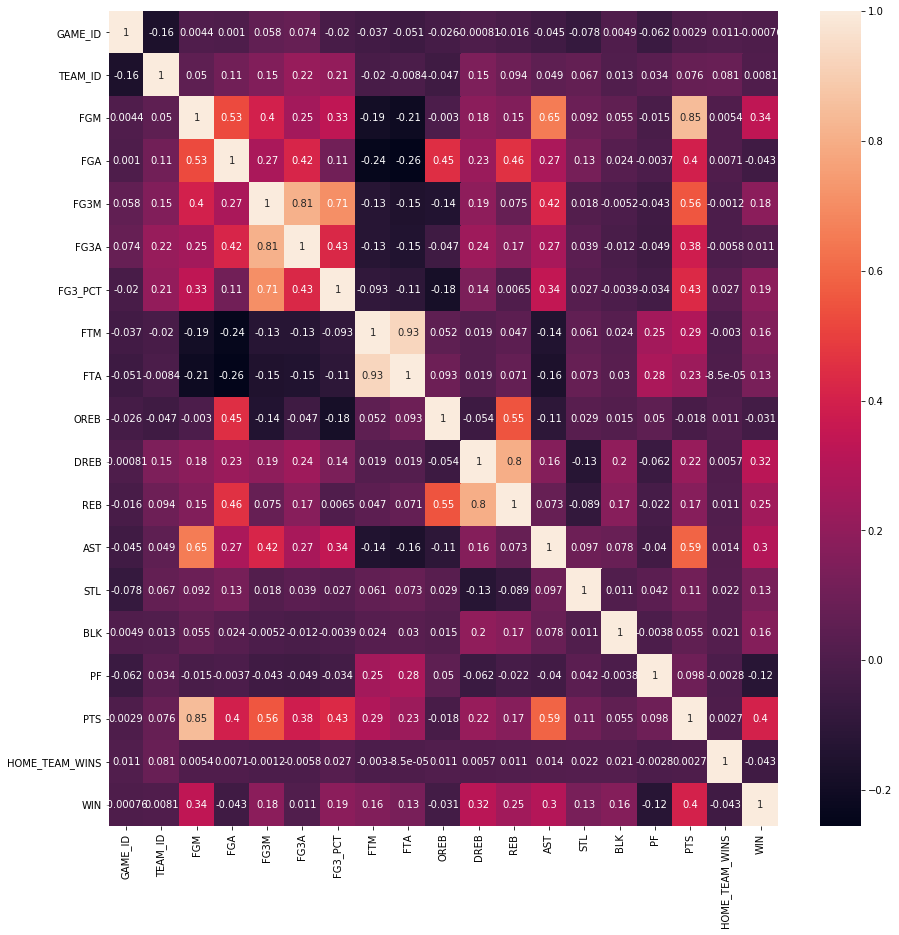

In [11]:
#Heat map of new game stats and their correlation
plt.figure(figsize = (15,15))
sns.heatmap(game_gp.corr(),annot=True)

Interesting that defensive rebounds have a correlation to wins, but offensive rebounds have no correlation at all

We now have a better picture of which stats correlate to a win.

However, to predict a game outcome, we cannot just use that game's stats. The whole point of predicting a game outcome is to do so before it occurs, so we obviously cannot use the same game stats to predict it's outcome. 

Intead we will use a moving average of the last X games to predict the outcome.

We wil also need to create a df that includes both the home AND away stats as the difference between the teams will be an important factor in predicting the outcome.